In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext watermark
%watermark -v -p numpy,torch,torchvision,cv2,PIL,matplotlib

CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3


In [5]:
import os, sys, io
import numpy as np
import cv2
import random
import PIL.Image as Image
import torch, torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
from IPython.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [8]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 80))

[SimHei Font: qsxp](https://pan.baidu.com/s/1AkoHvYbCYgLSJZDrCVv8RA "提取码: qsxp")

In [9]:
zh_font = FontProperties(fname='/data/font/simhei.ttf')

----------------------------

## Plate Detection Using Yolov5 (车牌提取)

### Dataset

[CCPD2019](https://github.com/detectRecog/CCPD)

[BaiduYun Drive(code: ol3j)](https://pan.baidu.com/s/1JSpc9BZXFlPkXxRK4qUCyw)

In [10]:
data_root = '/data/datasets/cv/CCPD2019'

!ls $data_root $data_root/splits

/data/datasets/cv/CCPD2019:
CCPD2019.tar.gz  ccpd_base	 ccpd_db  ccpd_rotate	images
LICENSE		 ccpd_blur	 ccpd_fn  ccpd_tilt	labels
README.md	 ccpd_challenge  ccpd_np  ccpd_weather	splits

/data/datasets/cv/CCPD2019/splits:
ccpd_blur.txt	    ccpd_db.txt  ccpd_rotate.txt  test.txt   val.txt
ccpd_challenge.txt  ccpd_fn.txt  ccpd_tilt.txt	  train.txt


In [11]:
%%bash

mkdir -p /data/codes

if [[ ! -d /data/codes/yolov5 ]]
then
    git clone https://github.com/ultralytics/yolov5 /data/codes/yolov5
    cd /data/codes/yolov5 && pip3 install -r requirements.txt > /dev/null
fi

### Data Preprocess

In [71]:
def read_data(phase, category=None):
    with open(os.path.join(data_root, 'splits', f'{phase}.txt')) as fr:
        # data = fr.readlines()
        data = fr.read().splitlines()
        if category is not None:
            data = [x for x in data if x[5:].startswith(category)]
    return data

In [73]:
test_data = read_data('test')

In [19]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", 
             "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]

alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U',
             'V', 'W', 'X', 'Y', 'Z', 'O']

ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
       'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

```
                           97&485_423&774
                      | {left up}_{right bottom}
                      |
   0         1        |   2                   3                         4               5            6
{area}-{tilt degree}-{bounding box}-{four vertices locations}-{license plate number}-{brightness}-{blurriness}
        |                                                       |
        | {horizontal tilt degree}_{vertical_tilt_degree}       |
                                27_21                           | {provinces}_{alphabets}_{ads}
                                                                         0_0_32_32_5_31_27
```

In [16]:
def parse_bbox_and_lpn(filename):
    segs = filename.split('-')
    bbox_vertices = segs[2].split('_')
    bbox_left_up = [int(x) for x in bbox_vertices[0].split('&')]
    bbox_right_bottom = [int(x) for x in bbox_vertices[1].split('&')]
    lps = [int(x) for x in segs[4].split('_')]
    return bbox_left_up, bbox_right_bottom, lps

def lpn_index2name(lpn):
    if len(lpn) != 7:
        raise
    return [provinces[lpn[0]]] + [alphabets[lpn[1]]] + [ads[lpn[i]] for i in range(2, 7)]

In [17]:
x1y1, x2y2, lpn = parse_bbox_and_lpn(test_data[-6])
x1y1, x2y2, lpn

([97, 485], [423, 774], [0, 0, 32, 32, 5, 31, 27])

In [18]:
x1y1, x2y2, lpn_index2name(lpn)

NameError: name 'provinces' is not defined

#### Visualize Single Sample 

In [13]:
sample_image_file = os.path.join(data_root, test_data[-6])
sample_image_rgb = cv2.cvtColor(cv2.imread(sample_image_file), cv2.COLOR_BGR2RGB)
image_height, image_width = sample_image_rgb.shape[0:2]
image_height, image_width, sample_image_rgb.shape

(1160, 720, (1160, 720, 3))

In [14]:
sample_image_box = cv2.rectangle(sample_image_rgb, tuple(x1y1), tuple(x2y2), (0, 255, 0), 2)

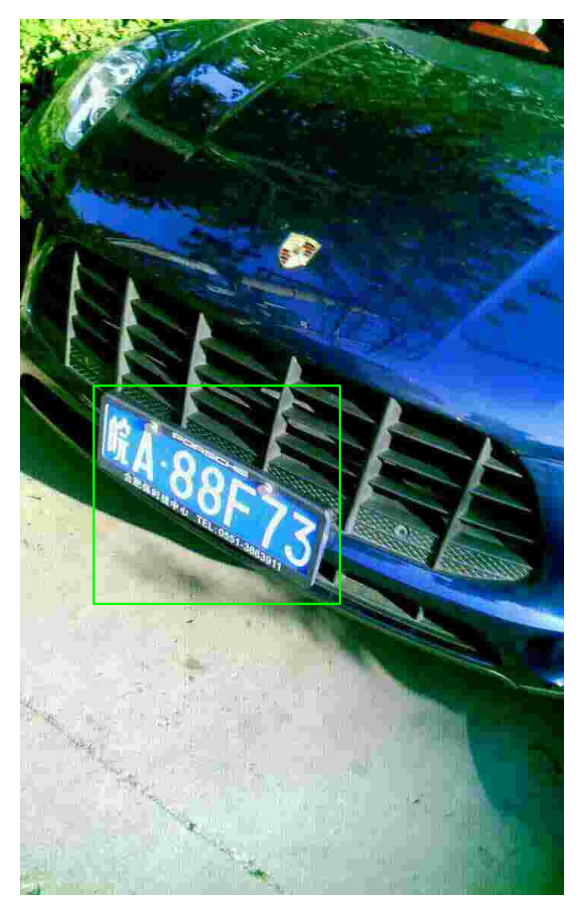

In [15]:
dpi = 100
fig_w, fig_h = 0.5*image_width/dpi, 0.5*image_height/dpi
plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
plt.imshow(sample_image_box)
plt.axis('off');

#### Visualize Subplots Sample 

[SimHei Font: qsxp](https://pan.baidu.com/s/1AkoHvYbCYgLSJZDrCVv8RA "提取码: qsxp")

In [24]:
zh_font = FontProperties(fname='/data/font/simhei.ttf', size=14)

def visualize_data_subplots(rows, cols, images, titles=None, gray=False, isbgr=False, resize=None, dpi=100, return_image=False):
    if isinstance(images[0], str):
        max_h, max_w = 0.8*rows*dpi, 0.8*cols*dpi
    else:
        max_h = max([ x.shape[0] for x in images])
        max_w = max([ x.shape[1] for x in images])
    figsize = (5 * int(max_w / dpi + 1), 5 * int(max_h / dpi + 1))
    fig = plt.figure(figsize=figsize, dpi=dpi)
    if titles is None:
        titles = [str(i) for i in range(1, len(images) + 1)]
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(titles[i], fontproperties=zh_font)
        # plt.xticks([])
        # plt.yticks([])
        plt.axis(False)
        img = images[i]
        if isinstance(img, str):
            img = cv2.imread(img)
            isbgr = True
        if resize:
            if isinstance(resize, int):
                resize = (resize, resize)
            img = cv2.resize(img, resize)
        if isbgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if gray:
            plt.imshow(img, cmap=plt.cm.gray)
        else: 
            plt.imshow(img)
    plt.tight_layout()
    if return_image:
        with io.BytesIO() as fw:
            plt.savefig(fw)
            fw.seek(0)
            return np.array(Image.open(fw)) 
    
def imshow(img, figsize=(8, 8), gray=False, isbgr=False):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if isbgr:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    if gray:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        plt.imshow(img)

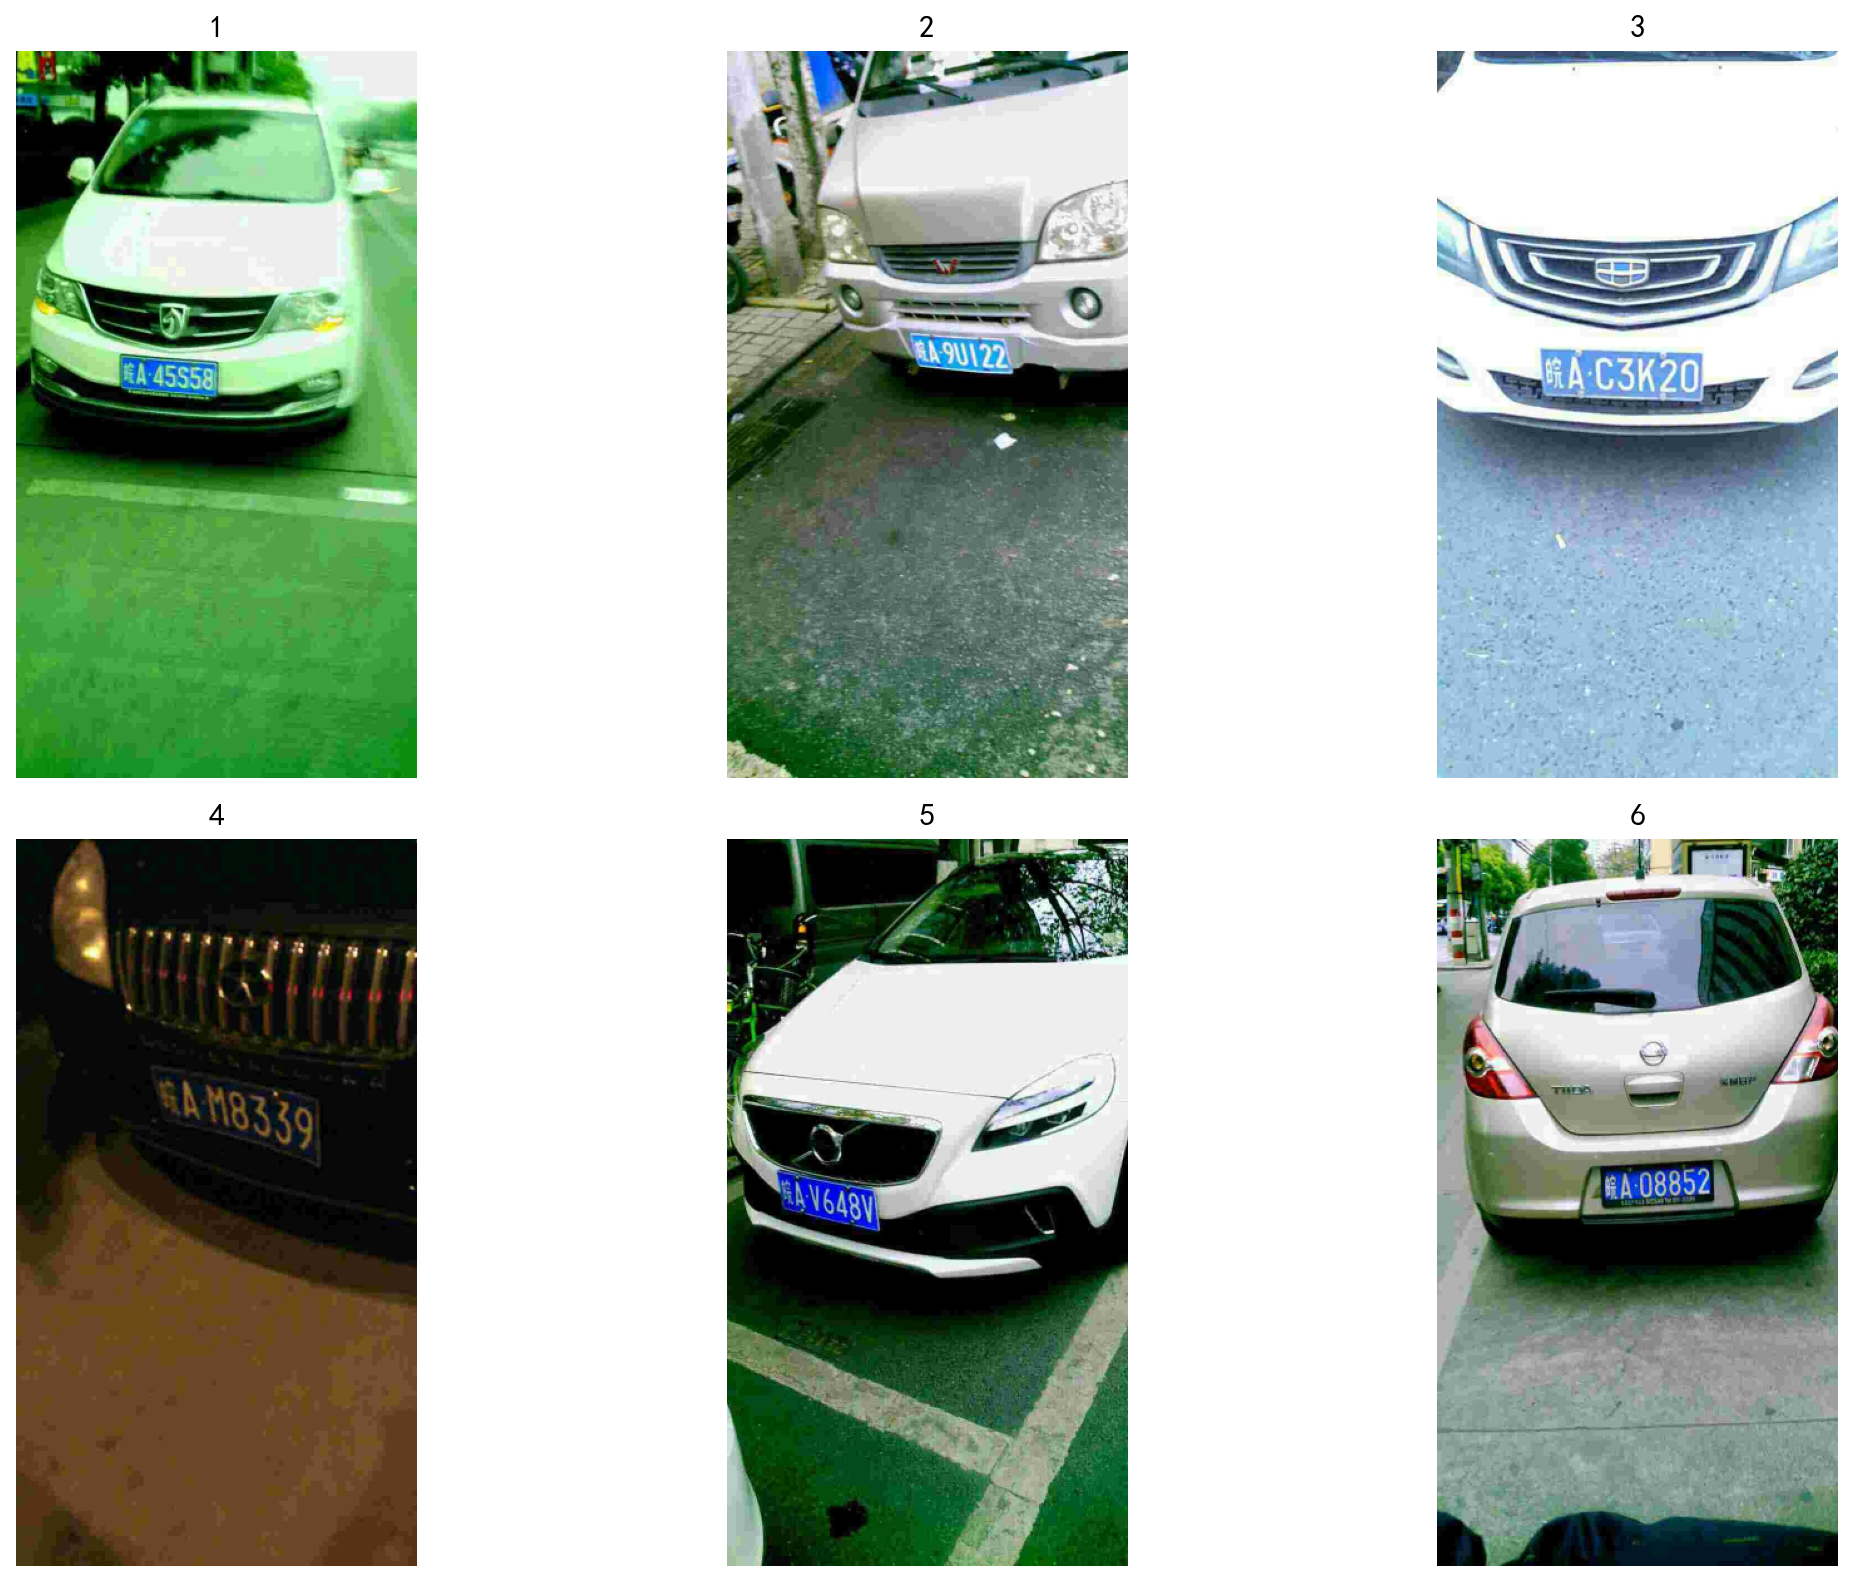

In [17]:
rows, cols = 2, 3
train_data = read_data('train')
images_sample_list = [os.path.join(data_root, train_data[i]) for i in range(cols*rows)]

visualize_data_subplots(rows, cols, images_sample_list, resize=(320, 580), dpi=80)

#### Data Convert to Yolov5 

In [18]:
def yolo_data_generate(phase, num=-1, force=False):
    # prepare data path
    phase_images_path = os.path.join(data_root, 'images', phase)
    phase_labels_path = os.path.join(data_root, 'labels', phase)
    if os.path.exists(phase_images_path) and \
        os.path.exists(phase_labels_path) and \
            not force:
                print(f'{phase} already exist')
                return
    os.makedirs(phase_images_path, exist_ok=True)
    os.makedirs(phase_labels_path, exist_ok=True)
    
    # parse file and format convert
    files_list = read_data(phase)
    if num > 0:
        files_list = files_list[:num]
    for filepath in files_list:
        basename = os.path.basename(filepath)
        image_src_path = os.path.join(data_root, filepath)
        image_dst_path = os.path.join(phase_images_path, basename)
        label_dst_path = os.path.join(phase_labels_path, basename.split('.')[0] + '.txt')
        x1y1, x2y2, _ = parse_bbox_and_lpn(basename)
        image_bgr = cv2.imread(image_src_path)
        bbox = yolo_normal_convert(image_bgr.shape[1], image_bgr.shape[0], *x1y1, *x2y2)
        ## generate label file
        with open(label_dst_path, 'w') as fw:
            fw.write('0 %.6f %.6f %.6f %.6f' % bbox)
        ## copy image file
        shutil.copy(image_src_path, image_dst_path)

In [19]:
yolo_data_generate('train', force=False)
yolo_data_generate('val', num=1000, force=False)
# yolo_data_generate('test', force=False)

train already exist
val already exist


In [20]:
def yolo_normal_convert(width, height, x1, y1, x2, y2):
    dw, dh = 1.0 / width, 1.0 / height
    bw, bh = (x2 - x1), (y2 - y1)
    cx, cy = (x1 + x2) / 2.0 - 1, (y1 + y2) / 2.0 - 1
    return round(cx * dw, 6), round(cy * dh, 6), round(bw * dw, 6), round(bh * dh, 6)
yolo_normal_convert(200, 200, 0, 0, 200, 200)

(0.495, 0.495, 1.0, 1.0)

### Yolov5 Train 

#### GPU Info

In [21]:
!nvidia-smi

Mon Apr 12 19:57:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:00:06.0 Off |                    0 |
| N/A   32C    P0    49W / 250W |   2156MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Download Yolov5 Codes

In [22]:
%%bash

mkdir -p /data/codes

export YOLOV5_ROOT=/data/codes/yolov5

if [[ ! -d $YOLOV5_ROOT ]]
then
    git clone https://github.com/ultralytics/yolov5 $YOLOV5_ROOT
    cd $YOLOV5_ROOT && pip3 install -r requirements.txt > /dev/null
fi

#### Setup Configure Files

- `${YOLOV5_ROOT}/data/CCPD2019/dataset.yaml`

> ```yaml
> train: /data/datasets/cv/CCPD2019/images/train   
> val: /data/datasets/cv/CCPD2019/images/val   
> 
> nc: 1
> 
> names: ['licenseplates']
> ```


- `${YOLOV5_ROOT}/data/CCPD2019/hyperparameters.yaml`

>```yaml
> lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)  
> lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)   
> momentum: 0.937  # SGD momentum/Adam beta1  
> weight_decay: 0.0005  # optimizer weight decay 5e-4  
> warmup_epochs: 3.0  # warmup epochs (fractions ok)   
> warmup_momentum: 0.8  # warmup initial momentum
> warmup_bias_lr: 0.1  # warmup initial bias lr
> box: 0.05  # box loss gain
> cls: 0.5  # cls loss gain
> cls_pw: 1.0  # cls BCELoss positive_weight
> obj: 1.0  # obj loss gain (scale with pixels)
> obj_pw: 1.0  # obj BCELoss positive_weight
> iou_t: 0.20  # IoU training threshold
> anchor_t: 4.0  # anchor-multiple threshold
> # anchors: 3  # anchors per output layer (0 to ignore)
> fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
> hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
> hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
> hsv_v: 0.4  # image HSV-Value augmentation (fraction)
> degrees: 0.0  # image rotation (+/- deg)
> translate: 0.1  # image translation (+/- fraction)
> scale: 0.5  # image scale (+/- gain)
> shear: 0.0  # image shear (+/- deg)
> perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
> flipud: 0.0  # image flip up-down (probability)
> fliplr: 0.5  # image flip left-right (probability)
> mosaic: 1.0  # image mosaic (probability)
> mixup: 0.0  # image mixup (probability)
> ```


- `${YOLOV5_ROOT}/data/CCPD2019/yolov5s.yaml`

> ```yaml
> # parameters
> nc: 1  # number of classes
> depth_multiple: 0.33  # model depth multiple
> width_multiple: 0.50  # layer channel multiple
> 
> # anchors
> anchors:
>   - [10,13, 16,30, 33,23]  # P3/8
>   - [30,61, 62,45, 59,119]  # P4/16
>   - [116,90, 156,198, 373,326]  # P5/32
> 
> # YOLOv5 backbone
> backbone:
>   # [from, number, module, args]
>   [[-1, 1, Focus, [64, 3]],  # 0-P1/2
>    [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
>    [-1, 3, BottleneckCSP, [128]],
>    [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
>    [-1, 9, BottleneckCSP, [256]],
>    [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
>    [-1, 9, BottleneckCSP, [512]],
>    [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
>    [-1, 1, SPP, [1024, [5, 9, 13]]],
>    [-1, 3, BottleneckCSP, [1024, False]],  # 9
>   ]
> 
> # YOLOv5 head
> head:
>   [[-1, 1, Conv, [512, 1, 1]],
>    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
>    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
>    [-1, 3, BottleneckCSP, [512, False]],  # 13
> 
>    [-1, 1, Conv, [256, 1, 1]],
>    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
>    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
>    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)
> 
>    [-1, 1, Conv, [256, 3, 2]],
>    [[-1, 14], 1, Concat, [1]],  # cat head P4
>    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)
> 
>    [-1, 1, Conv, [512, 3, 2]],
>    [[-1, 10], 1, Concat, [1]],  # cat head P5
>    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)
> 
>    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
>   ]
> ```

#### Execute Bash Script (DDP)

edit `$YOLOV5_ROOT/data/CCPD2019/train.sh`

```bash

#!/bin/bash

prog_name=$(basename $0)
master_addr=10.255.0.58
master_port=8555
nodes_num=1
procs_num=1
node_index=0
batch_size=96
ddp=False
level=s
out_dir=/data/result/CCPD2019

__usage() {
    echo ""
    echo "${prog_name} arguments:"
    echo "-m or --master master_addr:master_port"
    echo "-n or --nodes node/nnodes like 1/3"
    echo "-p or --procs num"
    echo "-l or --level"
    echo "-b or --bs batchsize"
    echo "-o or --output"
    echo "-h or --help"
    echo ""
}

ARGUMENT_LIST=(
    "master"
    "nodes"
    "procs"
    "level"
    "out"
    "bs"
)

opts=$(getopt \
    --options "$(printf "%.1s:" "${ARGUMENT_LIST[@]}")h::" \
    --longoptions "$(printf "%s:," "${ARGUMENT_LIST[@]}")help::" \
    --name "$prog_name" \
    -- "$@"
)

eval set --$opts

while [[ $# -gt 0 ]]; do
    case "$1" in
        -o|--out)
            out_dir=$2
            shift 2
            ;;

        -m|--master)
            ddp=True
            master_addr=`echo $2 | cut -d: -f1`
            master_port=`echo $2 | cut -d: -f2`
            shift 2
            ;;

        -n|--nodes)
            ddp=True
            nodes_num=`echo $2 | cut -d/ -f2`
            node=`echo $2 | cut -d/ -f1`
            node_index=`expr $node - 1`
            shift 2
            ;;

        -p|--procs)
            ddp=True
            procs_num=$2
            shift 2
            ;;

        -l|--level)
            ddp=True
            level=$2
            shift 2
            ;;

        -b|--bs)
            batch_size=$2
            shift 2
            ;;

        -h|--help)
            __usage && exit 1
            ;;

        *)
            break
            ;;
    esac
done

batch_size=`expr $batch_size \* $nodes_num`
data_root=data/CCPD2019

commargs="--img-size 640 --batch-size $batch_size --epochs 30 --device 0 \
    --workers 4 --project $out_dir --name $level --exist-ok \
    --data $data_root/dataset.yaml \
    --cfg $data_root/yolov5$level.yaml \
    --hyp $data_root/hyperparameters.yaml \
    --weights 'weights/yolov5$level.pt'"

__kill_resource() {
    pid=`ps -eo pid,args | grep "train.py" | grep -v "grep" | cut -c 1-6`
    if [[ x$pid != x ]]
    then
        echo "kill $pid"
        kill -9 $pid
    fi
}

__kill_resource

if [[ x$ddp == xTrue ]]
then
    echo "DDP run $batch_size"
    python3 -m torch.distributed.launch \
        --nproc_per_node=$procs_num --nnodes=$nodes_num --node=$node_index \
        --master_addr $master_addr --master_port $master_port \
        train.py $commargs
else
    python3 train.py $commargs
fi

__kill_resource

```

#### Start Train

Run `train.sh` in the `$YOLOV5_ROOT`.

A. Single Machine

```bash
./data/CCPD2019/train.sh --bs 64 --out /data/result/CCPD2019
```

B. Multiple GPUs (DDP), eg: I have 3 gpu machines

> node-1 (master)
> ```bash
> ./data/CCPD2019/train.sh --level s --bs 64 --out /data/result/CCPD2019 --nodes 1/3
> ```

> node-2
> ```bash
> ./data/CCPD2019/train.sh --level s --bs 64 --out /data/result/CCPD2019 --nodes 2/3
> ```


> node-3
> ```bash
> ./data/CCPD2019/train.sh --level s --bs 64 --out /data/result/CCPD2019 --nodes 3/3
> ```

#### Train Result

`tree /data/result/CCPD2019 `

> ```
> /data/result/CCPD2019/weights/
> ├── best.pt
> └── last.pt
> ```

### Yolov5 Detect

In [23]:
# add syspath
WEIGHTS_PATH = '/data/result/CCPD2019/weights/last.pt'
IMAGE_SIZE = 512

YOLOV5_ROOT = '/data/codes/yolov5'
PYYOLO_PATH = os.path.dirname(YOLOV5_ROOT)
import sys
if PYYOLO_PATH not in sys.path: 
    sys.path.append(PYYOLO_PATH)
    sys.path.append(YOLOV5_ROOT)
    
# import yolov5
from yolov5.models.experimental import attempt_load
from yolov5.utils.torch_utils import select_device
from yolov5.utils.datasets import LoadImages
from yolov5.utils.general import check_img_size, non_max_suppression
from yolov5.utils.general import scale_coords
from yolov5.utils.plots import plot_one_box

# detect
device = select_device(device='0')
model = attempt_load(WEIGHTS_PATH, map_location=device)
imgsz = check_img_size(IMAGE_SIZE, s=model.stride.max())
model = model.half() # amp
print(imgsz)

conf_thres = 0.35
iou_thres = 0.45

images_predbox_list = []
for img_path in images_sample_list:
    dataset = LoadImages(img_path, img_size=imgsz)
    path, img, im0, _ = next(iter(dataset))
    img = torch.from_numpy(img).to(device)
    img = img.half() / 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    pred = model(img, augment=False)[0]
    pred = non_max_suppression(pred, conf_thres, iou_thres)
    for i, det in enumerate(pred):
        if len(det) == 0:
            print(f'{path} is not detect pl')
            continue
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
        for *xyxy, conf, cls in reversed(det):
            images_predbox_list.append({
                'image_path': img_path,
                'pred_box': [int(x) for x in xyxy]
            })
            break # we only using first best for test
            
# print result
for jitem in images_predbox_list:
    imgpath = jitem['image_path']
    predbox = jitem['pred_box']
    print(os.path.basename(imgpath).split('-')[2], predbox)

Fusing layers... 
512
181&490_358&548 [186, 483, 364, 551]
329&442_511&520 [330, 448, 513, 517]
173&473_468&557 [183, 471, 480, 560]
255&369_564&505 [244, 365, 546, 502]
90&538_280&616 [87, 526, 276, 630]
301&521_492&580 [299, 519, 495, 580]


In [24]:
images_cropped_list = []
for jitem in images_predbox_list:
    imgpath = jitem['image_path']
    x1, y1, x2, y2 = jitem['pred_box']
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images_cropped_list.append(img[y1:y2, x1:x2, :])

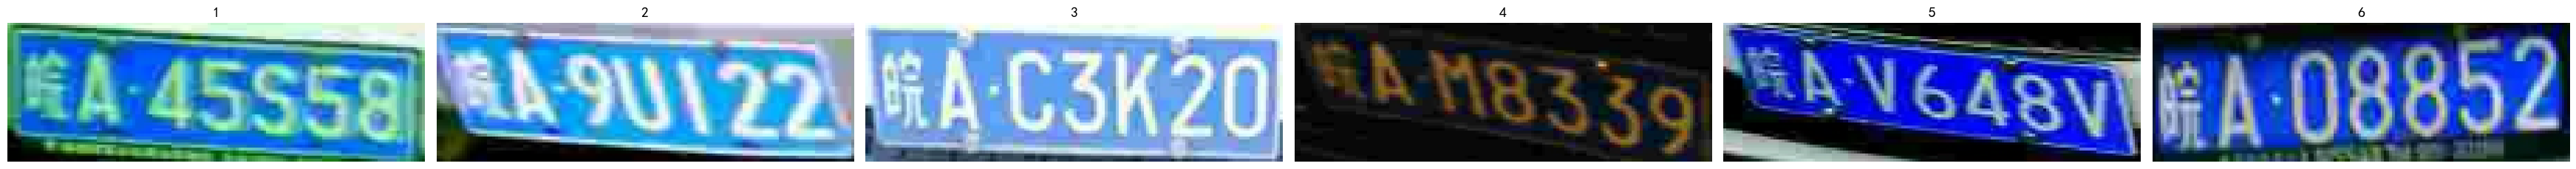

In [25]:
ncols = 6
nrows = int((len(images_sample_list) - 1) / ncols + 1)
visualize_data_subplots(nrows, ncols, images_cropped_list, resize=(150, 50), dpi=50)

### Test Summary

In [26]:
def LPDetect(model, img_path, conf_thres=0.35, iou_thres=0.45):
    device = next(model.parameters()).device
    imgsz = check_img_size(640, s=model.stride.max())
    dataset = LoadImages(img_path, img_size=imgsz)
    path, img, im0, _ = next(iter(dataset))
    img = torch.from_numpy(img).to(device)
    img = img.half() / 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    pred = model(img, augment=False)[0]
    pred = non_max_suppression(pred, conf_thres, iou_thres)
    if len(pred) > 0:
        det = pred[0]
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
        *xyxy, _conf, _cls = reversed(det)[0] # only best
        x1, y1, x2, y2 = [int(x.cpu()) for x in xyxy]
        # return im0[y1:y2, x1:x2, ::-1] # BGR to RGB
        return im0[y1:y2, x1:x2]
    return None

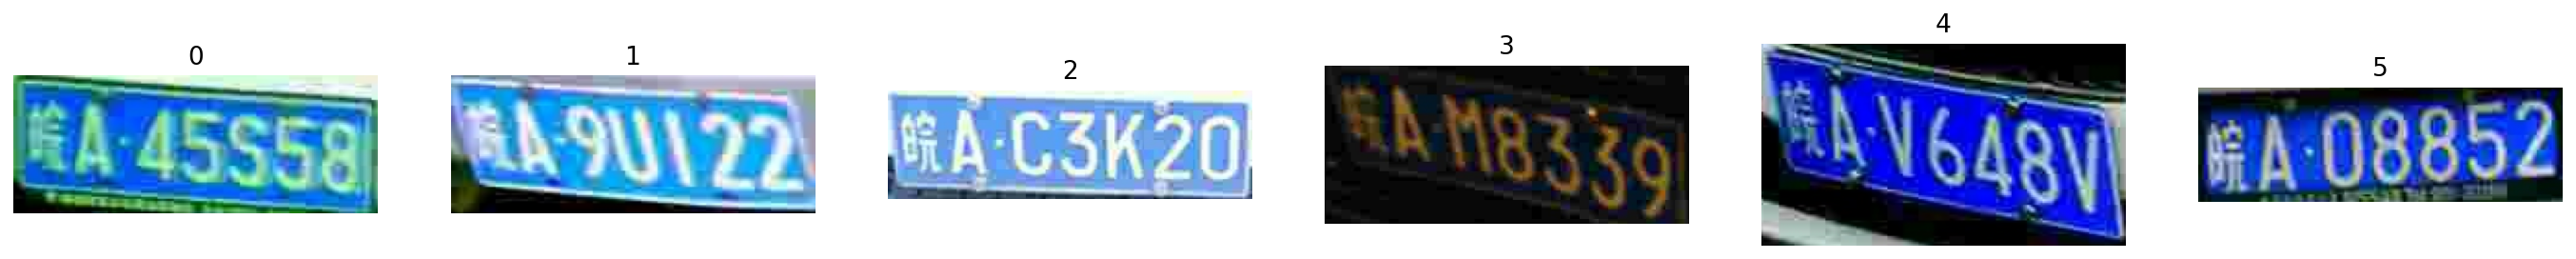

In [27]:
# Test
fig = plt.figure(figsize=(4*ncols, 2*nrows))

grid = gridspec.GridSpec(figure=fig, ncols=ncols, nrows=nrows, hspace=0.2, wspace=0.2)

lp_test_imgs = []
for i, path in enumerate(images_sample_list):
    imgbgr = LPDetect(model, path, 0.45, 0.5)
    if imgbgr is not None:
        fig.add_subplot(grid[i])
        plt.title(f'{i}')
        plt.axis(False)
        plt.imshow(imgbgr[:, :, ::-1])
        lp_test_imgs.append(imgbgr)

---------------

## LPRnet

### Dataset

In [89]:
train_data = read_data('train')
valid_data = read_data('val')

99996

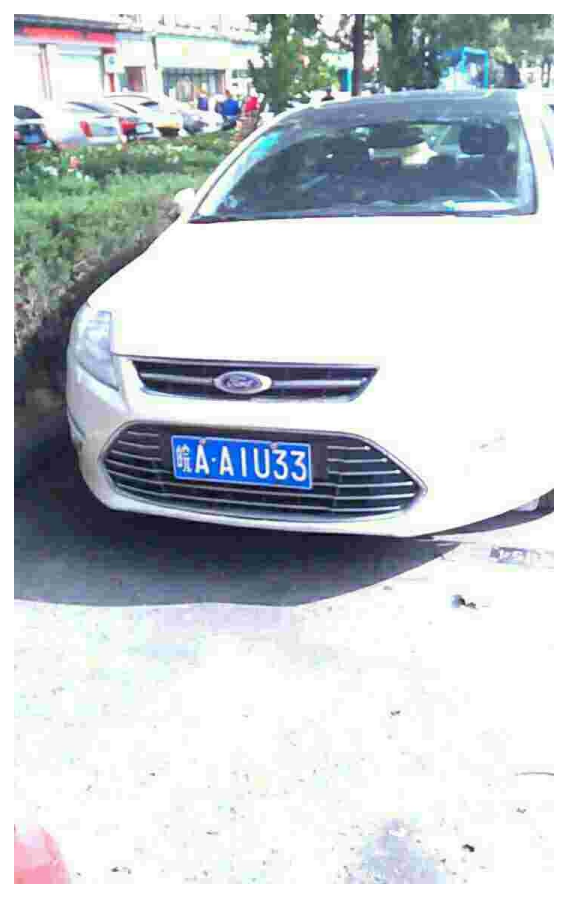

In [74]:
sample_image_file = os.path.join(data_root, train_data[-7])
sample_image_rgb = cv2.cvtColor(cv2.imread(sample_image_file), cv2.COLOR_BGR2RGB)
imshow(sample_image_rgb)

In [90]:
!ls $data_root

CCPD2019.tar.gz  ccpd_base	 ccpd_db  ccpd_rotate	images
LICENSE		 ccpd_blur	 ccpd_fn  ccpd_tilt	labels
README.md	 ccpd_challenge  ccpd_np  ccpd_weather	splits


In [91]:
valid_path = os.path.join(data_root, 'val')

os.makedirs(valid_path, exist_ok=True)

In [95]:
def generate_dataset(phase):
    data_path = os.path.join(data_root, phase)
    os.makedirs(data_path, exist_ok=True)
    data_list = read_data(phase)
    for file in data_list:
        imgpath = os.path.join(data_root, file)
        imgbgr = cv2.imread(imgpath)
        (x1, y1), (x2, y2), lpn = parse_bbox_and_lpn(file)
        imgnew = imgbgr[y1:y2, x1:x2, ::]
        imgrgb = cv2.resize(imgnew, (94, 24))
        cv2.imwrite(f'{data_path}/{"".join(lpn_index2name(lpn))}.jpg', imgrgb)

In [ ]:
generate_dataset('train')
generate_dataset('val')

ccpd_base/0314355842912-92_82-115&442_420&554-424&548_124&526_114&440_414&462-0_0_6_29_29_24_9-97-114.jpg
/data/datasets/cv/CCPD2019/ccpd_base/0314355842912-92_82-115&442_420&554-424&548_124&526_114&440_414&462-0_0_6_29_29_24_9-97-114.jpg
115 442 420 554 皖AG550K
(1160, 720, 3)
(112, 305, 3)


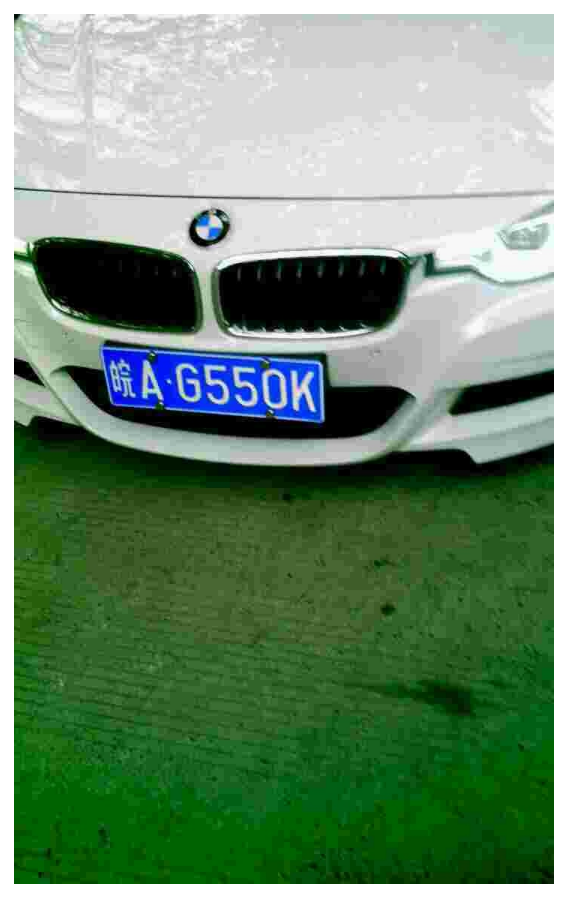

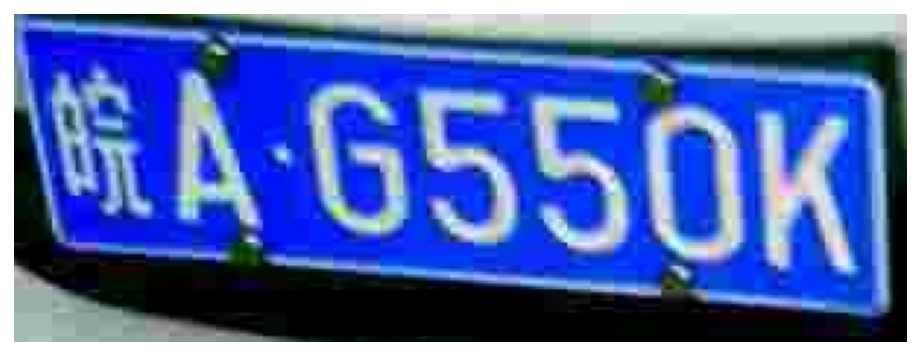

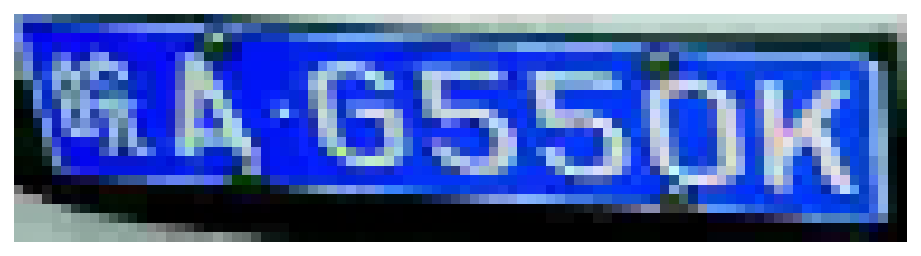

In [87]:
test_img_file = train_data[-16]
print(test_img_file)
sample_image_file = os.path.join(data_root, test_img_file)
sample_image_rgb = cv2.cvtColor(cv2.imread(sample_image_file), cv2.COLOR_BGR2RGB)
print(sample_image_file)
imshow(sample_image_rgb)

(x1, y1), (x2, y2), lpn = parse_bbox_and_lpn(sample_image_file)
print(x1, y1, x2, y2, ''.join(lpn_index2name(lpn)))
print(sample_image_rgb.shape)
new_img = sample_image_rgb[y1:y2, x1:x2, ::]
print(new_img.shape)
imshow(new_img)
imshow(cv2.resize(new_img, (94, 24)))

In [3]:
CHARS = [
    '京', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑',
    '苏', '浙', '皖', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤',
    '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁',
    '新',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
    'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
    'W', 'X', 'Y', 'Z', 'I', 'O', '-'
]
CHARS_DICT = {char:i for i, char in enumerate(CHARS)}